In [74]:
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import StandardScaler as zscore # zscore
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso #LRlasso
from joblib import dump, load #to save models in files
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re
import json

In [75]:
from sklearn.model_selection import GridSearchCV
def gridcv(X, y, model, param_grid, naimpute=False, prepy=True, scorer = 'neg_mean_squared_error', cv_meth = LeaveOneOut()):
    """
    Perform Cross-Validation (defaukt: LOOCV) with hyperparameter tuning using GridSearchCV.
    
    Parameters:
    ----------
    X : pandas DataFrame or numpy array
        The feature matrix.
        
    y : pandas Series or numpy array
        The target variable.
        
    model : scikit-learn estimator
        The machine learning model to be used, should be an uninitialized model instance 
        (e.g., Lasso(), not Lasso(alpha=1.0)).
        
    param_grid : dict
        Dictionary containing the hyperparameters to be tuned and their possible values. 
        The keys should be prefixed with 'regressor__' to work with the pipeline.
        
    naimpute : bool, optional (default=False)
        Toggle imputation for missing values. 
        Currently not implemented; will print a message and return 0 if set to True.
        
    prepy : bool, optional (default=True)
        Toggle preprocessing target variable 'y' by setting any negative values to zero.
        
    scorer : str, callable, or None, optional (default='neg_mean_squared_error')
        A string or a scorer callable object / function with signature scorer(estimator, X, y). 
        For valid scoring strings, see the scikit-learn documentation.
        
    cv_meth : cross-validation generator, optional (default=LeaveOneOut())
        A cross-validation splitting strategy. 
        Possible inputs for cv are integers to specify the number of folds in a (Stratified)KFold, 
        CV splitter, cross-validation generator iterators, or an iterable.
        
    Returns:
    -------
    overall_metric : dict
        Dictionary containing the overall metrics and other details from the GridSearchCV.
        
    out_model : GridSearchCV object
        Fitted GridSearchCV object.
        
    best_params : dict
        Dictionary containing the best hyperparameters found by GridSearchCV.

    Call:
    ------
    from sklearn.model_selection import KFold

    # set up KFold cross-validator
    kfold_cv = KFold(n_splits=3, shuffle=True, random_state=42)

    param_grid = {
        'regressor__alpha': np.array(np.arange(0.0125, 0.0425, 0.0025)),
        'regressor__fit_intercept': [True, False]
    }
    print(param_grid)

    # Call the gridcv function with KFold as the cross-validation method
    lasso_fullkfold_scores, lasso_fullkfold_model, best_param = gridcv(
        X, 
        y,
        Lasso(max_iter=4000),
        param_grid,
        scorer='r2', 
        cv_meth=kfold_cv
    )
    dump(lasso_fullkfold_model, './models/lasso_fullkfold_model.pkl') # save the model as .pkl
    """

    # overall_metric = {'CV': cv_meth, 'scoring_metric': scorer} originally
    overall_metric = {'CV': str(cv_meth), 'scoring_metric': str(scorer)} # transformed to string because json dump scores later

    if prepy:
        y[y < 0] = 0
    
    if naimpute:
      print("not implemented")
      return 0


    pipeline = Pipeline([
        ('scaler', zscore()), 
        ('regressor', model)        # Regression model
    ])

    
    # declaring an Grid object
    # score : https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    out_model = GridSearchCV(pipeline, param_grid=param_grid, cv=cv_meth, scoring=scorer).fit(X,y)
    # GridSearchCV need the regressor__ prefix for the pipiline object in the para_grid later when called

    best_pipeline = out_model.best_estimator_
    y_pred = best_pipeline.predict(X)

    overall_metric['correlation_true_pred'] = list(np.corrcoef(list(y), list(y_pred)))
    overall_metric['correlation_true_pred'][0] = list(overall_metric['correlation_true_pred'][0])
    overall_metric['correlation_true_pred'][1] = list(overall_metric['correlation_true_pred'][1])


    # LOOCV folds: split{i}_test_score (number of data points minus one) 
    overall_metric['fold_scores'] = [out_model.cv_results_[f'split{i}_test_score'][out_model.best_index_] for i in range(out_model.n_splits_)]
    best_params = out_model.best_params_


    # access the 'regressor' step from the best pipeline and then its coefficients
    coefficients = best_pipeline.named_steps['regressor'].coef_
    overall_metric['non_zero_coefficients'] = coefficients[coefficients != 0]
    overall_metric['non_zero_coefficients'] = overall_metric['non_zero_coefficients'].tolist()
    overall_metric['non_zero_features'] = list(X.columns[np.where(coefficients != 0)[0]])

    # printing section
    print("best parameter from gridsearch>>\n", out_model.best_params_)
    print(overall_metric['CV'])
    print(overall_metric['scoring_metric'])
    print("correlation Matrix>>\n", overall_metric['correlation_true_pred'])
    print("non_zero_features>>\n",overall_metric['non_zero_features'])
    print("scores for each fold>>\n",overall_metric['fold_scores'])

    return overall_metric, out_model, best_params


# Data
> mutual sample points for transcriptome and GC-MS data


In [76]:
tr_mut = pd.read_csv("/home/t44p/PW_rawdata/tr_gc_mutual/tr_mut.csv", sep=",")
gcms_mut = pd.read_csv("/home/t44p/PW_rawdata/tr_gc_mutual/gcms_mut.csv", sep=",")


In [77]:
#X = tr_mut.transpose()
#X.columns =X.iloc[0]
#print(X.columns[0])
#print(tr_mut['ref'].iloc[-1])
#X.iloc[0,0]
#X.to_csv("/home/t44p/PW_rawdata/tr_gc_mutual/tr_mut_transposed.csv", index=False)
# X to big so deleted 2nd row after transpose (those are the columns name that wher row names before)
X = pd.read_csv("/home/t44p/PW_rawdata/tr_gc_mutual/tr_mut_transposed.csv", sep=",")

## Preparing targets

In [78]:
y_sucrose = gcms_mut.iloc[59,1:]
y_citricAcid = gcms_mut.iloc[13,1:]
y_glucose = gcms_mut.iloc[23,1:]

# Data exploration

## Distribution of target variable

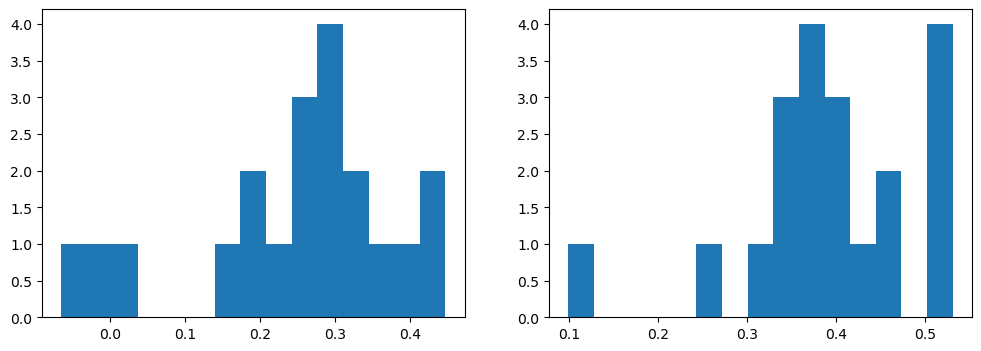

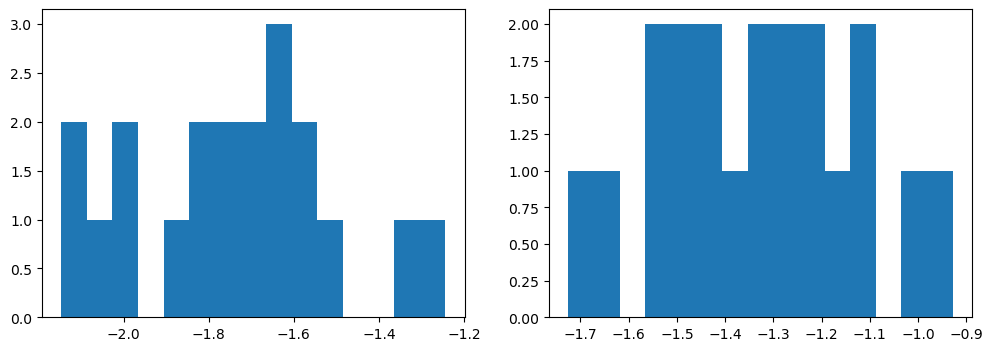

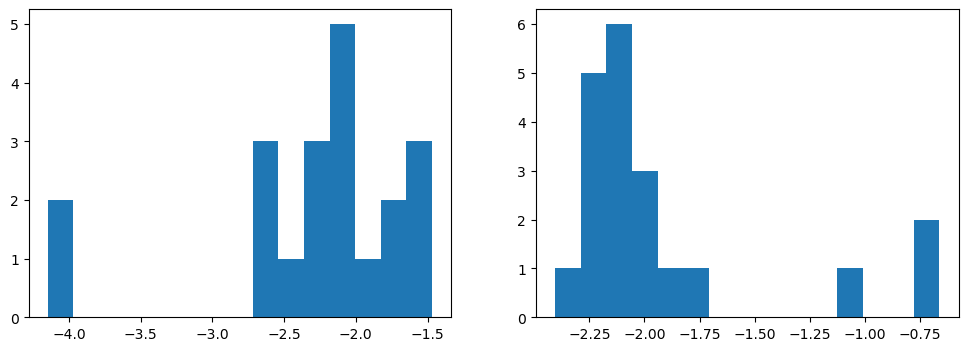

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns
axes[0].hist(y_sucrose[0:20], bins=15) # bins sqrt(samples), small sample, bins=n
axes[1].hist(y_sucrose[20:], bins=15) # bins sqrt(samples), small sample, bins=n
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns
axes[0].hist(y_citricAcid[0:20], bins=15) # bins sqrt(samples), small sample, bins=n
axes[1].hist(y_citricAcid[20:], bins=15) # bins sqrt(samples), small sample, bins=n
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns
axes[0].hist(y_glucose[0:20], bins=15) # bins sqrt(samples), small sample, bins=n
axes[1].hist(y_glucose[20:], bins=15) # bins sqrt(samples), small sample, bins=n
plt.show()


## GC-MS Levels over desiccation and rehydration series

/tmp/ipykernel_9820/2763618618.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(gcms_mut.columns[1:21], rotation=90)


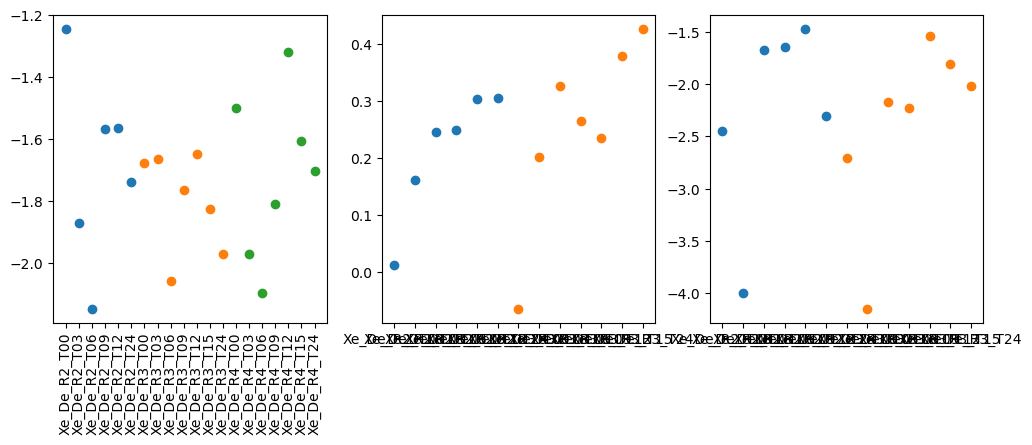

/tmp/ipykernel_9820/2763618618.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(gcms_mut.columns[7:14], rotation=90)
/tmp/ipykernel_9820/2763618618.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(gcms_mut.columns[7:14], rotation=90)
/tmp/ipykernel_9820/2763618618.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(gcms_mut.columns[7:14], rotation=90)


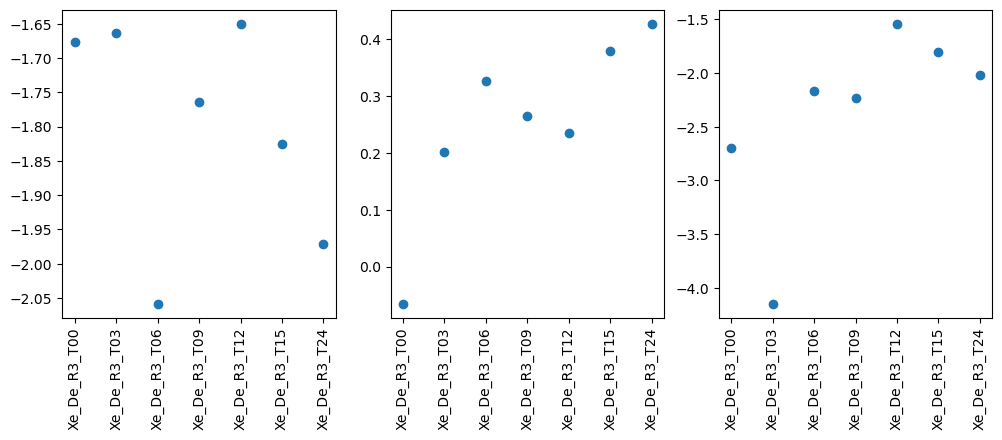

/tmp/ipykernel_9820/2763618618.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(gcms_mut.columns[1:7], rotation=90)
/tmp/ipykernel_9820/2763618618.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(gcms_mut.columns[1:7], rotation=90)
/tmp/ipykernel_9820/2763618618.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(gcms_mut.columns[1:7], rotation=90)


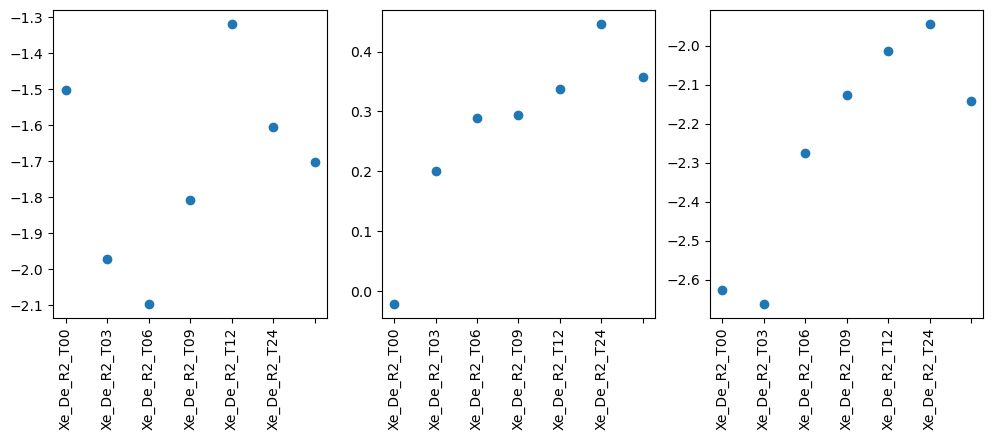

In [80]:
# replicate 2
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns
axes[0].scatter(gcms_mut.columns[1:7], y_citricAcid[0:6])
axes[0].scatter(gcms_mut.columns[7:14], y_citricAcid[6:13])
axes[0].scatter(gcms_mut.columns[14:21], y_citricAcid[13:20])
axes[0].set_xticklabels(gcms_mut.columns[1:21], rotation=90)

#axes[0].set_xticklabels(gcms_mut.columns[7:14], rotation=90)


axes[1].scatter(gcms_mut.columns[1:7], y_sucrose[0:6])
axes[1].scatter(gcms_mut.columns[7:14], y_sucrose[6:13])

#axes[1].set_xticklabels(gcms_mut.columns[1:7], rotation=90)
axes[2].scatter(gcms_mut.columns[1:7], y_glucose[0:6])
axes[2].scatter(gcms_mut.columns[7:14], y_glucose[6:13])
#axes[2].set_xticklabels(gcms_mut.columns[1:7], rotation=90)
plt.show()

# replicate 3
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns
axes[0].scatter(gcms_mut.columns[7:14], y_citricAcid[6:13])
axes[0].set_xticklabels(gcms_mut.columns[7:14], rotation=90)
axes[1].scatter(gcms_mut.columns[7:14], y_sucrose[6:13])
axes[1].set_xticklabels(gcms_mut.columns[7:14], rotation=90)
axes[2].scatter(gcms_mut.columns[7:14], y_glucose[6:13])
axes[2].set_xticklabels(gcms_mut.columns[7:14], rotation=90)
plt.show()

# replicate 4
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns
axes[0].scatter(gcms_mut.columns[14:21], y_citricAcid[13:20])
axes[0].set_xticklabels(gcms_mut.columns[1:7], rotation=90)
axes[1].scatter(gcms_mut.columns[14:21], y_sucrose[13:20])
axes[1].set_xticklabels(gcms_mut.columns[1:7], rotation=90)
axes[2].scatter(gcms_mut.columns[14:21], y_glucose[13:20])
axes[2].set_xticklabels(gcms_mut.columns[1:7], rotation=90)
plt.show()



In [81]:
# set up KFold cross-validator
kfold_cv = KFold(n_splits=3, shuffle=True, random_state=42)

param_grid = {
    'regressor__alpha': np.array(np.arange(0.0125, 0.0425, 0.0025)),
    'regressor__fit_intercept': [True, False]
}
print(param_grid)

# Call the gridcv function with KFold as the cross-validation method
# Lasso(max_iter=4000),

lasso_cvsucrose_scores, lasso_cvsucrose_model, best_param = gridcv(
    X, 
    y_sucrose,
    Lasso(),
    param_grid,
    prepy=False,
    scorer='r2', 
    cv_meth=kfold_cv
)
dump(lasso_cvsucrose_model, './models/lasso_cvsucrose_model.pkl') # save the model as .pkl
with open("./models/lasso_cvsucrose_scores.json", 'w') as file:
    json.dump(lasso_cvsucrose_scores, file)
    #file.write(str(lasso_cvsucrose_scores))
file.close()


{'regressor__alpha': array([0.0125, 0.015 , 0.0175, 0.02  , 0.0225, 0.025 , 0.0275, 0.03  ,
       0.0325, 0.035 , 0.0375, 0.04  ]), 'regressor__fit_intercept': [True, False]}


best parameter from gridsearch>>
 {'regressor__alpha': 0.015000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.9803378966370346], [0.9803378966370345, 1.0]]
non_zero_features>>
 ['Xele.ptg000034l.205', 'Xele.ptg000068l.7', 'Xele.ptg000014l.41', 'Xele.ptg000020l.374', 'Xele.ptg000049l.247', 'Xele.ptg000012l.303', 'Xele.ptg000012l.442', 'Xele.ptg000012l.930', 'Xele.ptg000003l.491', 'Xele.ptg000009l.79', 'Xele.ptg000009l.94', 'Xele.ptg000009l.119', 'Xele.ptg000009l.442', 'Xele.ptg000023l.177', 'Xele.ptg000101l.69', 'Xele.ptg000038l.4', 'Xele.ptg000024l.297', 'Xele.ptg000025l.266', 'Xele.ptg000043l.106', 'Xele.ptg000043l.346', 'Xele.ptg000063l.174', 'Xele.ptg000059l.69', 'Xele.ptg000008l.151', 'Xele.ptg000008l.209']
scores for each fold>>
 [0.6458811926086696, 0.6376259666067934, 0.0850928645261051]


In [82]:
# set up KFold cross-validator
kfold_cv = KFold(n_splits=3, shuffle=True, random_state=42)

param_grid = {
    'regressor__alpha': np.array(np.arange(0.0125, 0.0425, 0.0025)),
    'regressor__fit_intercept': [True, False]
}
print(param_grid)

# Call the gridcv function with KFold as the cross-validation method
# Lasso(max_iter=4000),

lasso_cvglucose_scores, lasso_cvglucose_model, best_param = gridcv(
    X, 
    y_glucose,
    Lasso(),
    param_grid,
    prepy=False,
    scorer='r2', 
    cv_meth=kfold_cv
)
dump(lasso_cvglucose_model, './models/lasso_cvglucose_model.pkl') # save the model as .pkl


with open("./models/lasso_cvglucose_scores.json", 'w') as file:
    json.dump(lasso_cvglucose_scores, file)
    #file.write(str(lasso_cvsucrose_scores))
file.close()


{'regressor__alpha': array([0.0125, 0.015 , 0.0175, 0.02  , 0.0225, 0.025 , 0.0275, 0.03  ,
       0.0325, 0.035 , 0.0375, 0.04  ]), 'regressor__fit_intercept': [True, False]}


best parameter from gridsearch>>
 {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.9994904088361716], [0.9994904088361715, 1.0]]
non_zero_features>>
 ['Xele.ptg000011l.301', 'Xele.ptg000011l.430', 'Xele.ptg000010l.105', 'Xele.ptg000068l.74', 'Xele.ptg000067l.472', 'Xele.ptg000018l.1563', 'Xele.ptg000016l.332', 'Xele.ptg000001l.144', 'Xele.ptg000007l.71', 'Xele.ptg000007l.418', 'Xele.ptg000012l.772', 'Xele.ptg000044l.31', 'Xele.ptg000044l.564', 'Xele.ptg000028l.519', 'Xele.ptg000003l.525', 'Xele.ptg000013l.459', 'Xele.ptg000013l.792', 'Xele.ptg000331l.2', 'Xele.ptg000023l.344', 'Xele.ptg000021l.354', 'Xele.ptg000024l.325', 'Xele.ptg000006l.423', 'Xele.ptg000006l.592', 'Xele.ptg000006l.630', 'Xele.ptg000025l.124', 'Xele.ptg000025l.274', 'Xele.ptg000025l.374', 'Xele.ptg000043l.202', 'Xele.ptg000056l.25', 'Xele.ptg000063l.57', 'Xele.ptg000063l.174', 'Xele.ptg000008l.432', 'Xele.ptg000022l.101',

In [83]:
# set up KFold cross-validator
kfold_cv = KFold(n_splits=3, shuffle=True, random_state=42)

param_grid = {
    'regressor__alpha': np.array(np.arange(0.0125, 0.0425, 0.0025)),
    'regressor__fit_intercept': [True, False]
}
print(param_grid)

# Call the gridcv function with KFold as the cross-validation method
# Lasso(max_iter=4000),

lasso_cvcitricAcid_scores, lasso_cvcitricAcid_model, best_param = gridcv(
    X, 
    y_citricAcid,
    Lasso(),
    param_grid,
    prepy=False,
    scorer='r2', 
    cv_meth=kfold_cv
)
dump(lasso_cvcitricAcid_model, './models/lasso_cvcitricAcid_model.pkl') # save the model as .pkl
with open("./models/lasso_cvcitricAcid_scores.json", 'w') as file:
    json.dump(lasso_cvcitricAcid_scores, file)
    #file.write(str(lasso_cvsucrose_scores))
file.close()


{'regressor__alpha': array([0.0125, 0.015 , 0.0175, 0.02  , 0.0225, 0.025 , 0.0275, 0.03  ,
       0.0325, 0.035 , 0.0375, 0.04  ]), 'regressor__fit_intercept': [True, False]}


best parameter from gridsearch>>
 {'regressor__alpha': 0.025, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.9895817177601468], [0.9895817177601468, 1.0]]
non_zero_features>>
 ['Xele.ptg000045l.82', 'Xele.ptg000011l.21', 'Xele.ptg000011l.328', 'Xele.ptg000018l.209', 'Xele.ptg000041l.62', 'Xele.ptg000020l.342', 'Xele.ptg000020l.540', 'Xele.ptg000049l.171', 'Xele.ptg000012l.70', 'Xele.ptg000012l.134', 'Xele.ptg000028l.203', 'Xele.ptg000028l.243', 'Xele.ptg000004l.76', 'Xele.ptg000042l.33', 'Xele.ptg000042l.232', 'Xele.ptg000047l.208', 'Xele.ptg000009l.645', 'Xele.ptg000023l.139', 'Xele.ptg000023l.251', 'Xele.ptg000005l.569', 'Xele.ptg000026l.188', 'Xele.ptg000025l.209', 'Xele.ptg000025l.266', 'Xele.ptg000055l.154', 'Xele.ptg000059l.297', 'Xele.ptg000022l.500', 'Xele.ptg000022l.1106', 'Xele.ptg000022l.1164', 'Xele.ptg000022l.1456', 'Xele.ptg000046l.302']
scores for each fold>>
 [0.43498892935234024, 0.4550706276789592, 

# Non-Zero features for Sucrose Model in GFF

In [125]:
lasso_sucrose_feat_matched = matchgff(lasso_cvsucrose_scores['non_zero_features'])
with open("./models/lasso_sucrose_feat_matched.txt", 'w') as file:
    #file.write(str(lasso_sucrose_feat_matched))
    for ele in lasso_sucrose_feat_matched:
        file.write(ele)
        file.write("\n")

        for lel in lasso_sucrose_feat_matched[ele]:
            file.write(lel)
            file.write("\n")
        file.write("\n")


# Non-Zero features for Glucose Model in GFF

In [ ]:
lasso_sucrose_feat_matched = matchgff(lasso_cvsucrose_scores['non_zero_features'])
with open("./models/lasso_sucrose_feat_matched.txt", 'w') as file:
    #file.write(str(lasso_sucrose_feat_matched))
    for ele in lasso_sucrose_feat_matched:
        file.write(ele)
        file.write("\n")

        for lel in lasso_sucrose_feat_matched[ele]:
            file.write(lel)
            file.write("\n")
        file.write("\n")
